# Problem Set 4, due March 16 at 11:59pm

### Before You Start

This is a fun but challenging problem set. It will test your python skills, as well as your understanding of the material in class and in the readings. Start early and debug often! Some notes:

* Part 1 is meant to be easy, so get through it quickly.
* Part 2 (especially 2.1) will be difficult, but it is the lynchpin of this problem set to make sure to do it well and understand what you've done. If you find your gradient descent algorithm is taking more than a few minutes to complete, debug more, compare notes with others, and go to the TA sessions (especially the sections on vectorized computation and computational efficiency).
* Depending on how well you've done 2.1, parts 2.3 and 4.3 will be relatively painless or incredibly painful. 
* Part 4 (especially 4.3) will be computationally intensive. Don't leave this until the last minute, otherwise your code might be running when the deadline arrives.
* Do the extra credit problems last.

---

## Introduction to the assignment

As with the last assignment, you will be using the [Boston Housing Prices Data Set](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names).

In [576]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn

%matplotlib inline  
import matplotlib.pyplot as plt  
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf


In [577]:
# Load you data the Boston Housing data into a dataframe
# MEDV.txt containt the median house values and data.txt the other 13 features
# in order ["CRIM", "ZN", "INDUS", "CHAS", "NOX","RM","AGE","DIS","RAD","TAX","PTRATIO","B","LSTAT"]

datatxt = np.loadtxt('data.txt')
MEDVtxt = np.loadtxt('MEDV.txt')

data = pd.DataFrame(datatxt, columns = ["CRIM", "ZN", "INDUS", "CHAS", "NOX","RM","AGE","DIS","RAD","TAX","PTRATIO","B","LSTAT"])
data['MEDV'] = MEDVtxt

data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.218960,18.0,2.629288,0.0,0.869420,6.875396,65.2,4.347275,1.0,307.0,15.534711,397.462329,5.715647,24.0
1,0.141576,0.0,7.315612,0.0,0.549711,6.499894,78.9,5.315684,2.0,255.0,17.914131,397.012611,9.338417,21.6
2,0.380457,0.0,7.340354,0.0,0.697928,7.263489,61.1,5.356935,2.0,243.0,17.919989,396.628236,4.142473,34.7
3,0.313563,0.0,2.562407,0.0,0.599629,7.209732,45.8,6.103983,3.0,226.0,18.979527,398.564784,3.239272,33.4
4,0.330105,0.0,2.497337,0.0,0.476077,7.184111,54.2,6.264372,3.0,234.0,18.708888,399.487766,6.115159,36.2


---

## Part 1: Getting oriented


### 1.1 Use existing libraries

Soon, you will write your own gradient descent algorithm, which you will then use to minimize the squared error cost function.  First, however, let's use the canned versions that come with Python, to make sure we understand what we're aiming to achieve.

Using the same Boston housing prices dataset, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to explore the relationship between  median housing price and number of rooms per house. Do this by first (a) regressing the housing price on the number of rooms per house, and then (b) regressing the housing price on the number of rooms per house and the (number of rooms per house) squared.  Interpret your results.

In [578]:
def compute_rmse(predictions, observed):
    rmse = np.sqrt(np.sum((predictions - observed)**2)/len(predictions))
    return rmse

Mean Squared Error Cost for room = 6.67
Mean Squared Error Cost for room and room squared = 6.24
Linear Model Coefficients = 8.96
Quadratic Model Coefficients = -23.79,2.47


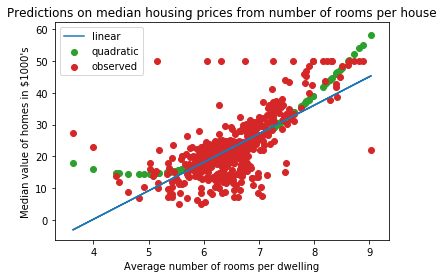

In [579]:
## (a) regressing the housing price on the number of rooms per house

rm = data[['RM']]
y = data['MEDV']
LR1 = LinearRegression().fit(rm, y)
pred1 = LR1.predict(rm)
cost1 = compute_rmse(pred1, y)

## (b) regressing the housing price on the number of rooms per house and the (number of rooms per house) squared.

rm2 = rm.copy()
rm2['RM2'] = rm**2
LR2 = LinearRegression().fit(rm2, y)
pred2 = LR2.predict(rm2)
cost2 = compute_rmse(pred2, y)

plt.plot(rm ,pred1, c='C0', label='linear')
plt.scatter(rm ,pred2, c='C2', label='quadratic')
plt.scatter(rm, y, c = 'C3',label='observed')
plt.title("Predictions on median housing prices from number of rooms per house")
plt.xlabel("Average number of rooms per dwelling")
plt.ylabel("Median value of homes in $1000's")
plt.legend()

print('Mean Squared Error Cost for room = {:.2f}'.format(cost1))
print('Mean Squared Error Cost for room and room squared = {:.2f}'.format(cost2))
print('Linear Model Coefficients = {:.2f}'.format(LR1.coef_[0]))
print('Quadratic Model Coefficients = {:.2f},{:.2f}'.format(LR2.coef_[0],LR2.coef_[1]))

Looking at the plot above, we see that our linear model and quadratic model both follows the trend of the data pretty well. Some issues we see is that there are some outliers where the data points are scattered around the graph. From our mean squared error costs, we see that the model that includes rm and rm^2 features has a lowest cost compared to the model that only uses the rm feature. 

### 1.2 Training and testing

Chances are, for the above problem you used all of your data to fit the regression line. In some circumstances this is a reasonable thing to do, but often this will result in overfitting. Let's redo the above results the ML way, using careful cross-validation.  Since you are now experts in cross-validation, and have written your own cross-validation algorithm from scratch, you can now take a shortcut and use the libraries that others have built for you.

Using the [cross-validation functions](http://scikit-learn.org/stable/modules/cross_validation.html) from scikit-learn, use 25-fold cross-validation to fit regression (a) above, i.e. the linear fit of housing price on number of rooms per house. Each fold of cross-validation will give you one slope coefficient and one intercept coefficient.  Plot the distribution of the 25 slope coefficients using a histogram, then draw a vertical line at the value of the slope coefficient that you estimated in 1.1 using the full dataset.  What do you notice?

In [580]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=25)
y = data[['MEDV']]

train_index = []
test_index = []
for train, test in kf.split(rm):
    train_index.append(train)
    test_index.append(test)

coefficients = np.zeros(25)
for i in range(25):
    LR = LinearRegression().fit(rm.iloc[train_index[i],:], y.iloc[train_index[i],:])
    coefficients[i] = LR.coef_[0]

    
print('Slope coefficients for each kfold \n = {}'.format(coefficients))  
print('Average of slope coefficients in 1.2 = {}'.format(np.mean(coefficients)))
print('value of slope coefficient in 1.1 = {}'.format(LR1.coef_[0]))



Slope coefficients for each kfold 
 = [8.94682556 8.89463907 8.9603567  8.98419985 8.94375822 8.99403578
 8.94901254 8.79793532 8.86389089 8.42086688 8.96647507 8.83902895
 8.65941046 8.51651748 8.89746381 9.00426798 8.97467577 9.61858367
 9.74689177 8.74894341 9.1583665  9.00180018 9.08203655 8.9746311
 8.99684028]
Average of slope coefficients in 1.2 = 8.957658151090296
value of slope coefficient in 1.1 = 8.959927212241066


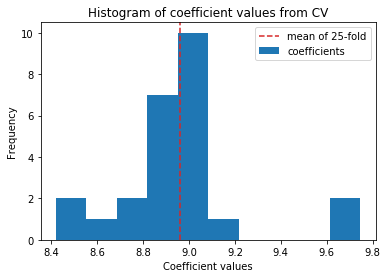

In [581]:
plt.hist(coefficients, label='coefficients')

plt.title("Histogram of coefficient values from CV")
plt.xlabel("Coefficient values")
plt.ylabel("Frequency")
plt.axvline(LR1.coef_[0], c='C3', ls='--', label='mean of 25-fold')
plt.legend()

Looking at the graph above, we see the frequency of the different coefficient values. The coefficient values range from 8.4 to 9.7. The coefficient value from 1.1 is 8.96. We see that this value lies at the highest frequency coefficient value from the graph. I guess this should make sense because the coefficient value form 1.1 is taken from all the observations/.

### 1.3 Regression lines

Create a scatterplot of housing price on rooms per house, and add the two regression lines from 1.1 (or 1.2 if you prefer to do so). Show the linear regression line in red, and the linear+quadratic regression line (which may have curvature) in blue.  Label these two regression lines with the corresponding regression equations (i.e. the slope and intercept of the line).

Bonus: Add the 95% confidence bands (i.e.,  the area that has a 95% chance of containing the true regression line) to each of these lines.

Note: You can get 2 points even without the confidence bands (if the other lines are correct, the axes are labeled, the lines are labeled, the points are plotted correctly, and so forth). If you do everything perfectly including the confidence bands, you get 2 points. If you do something else wrong and would normally receive less than two points, the confidence intervals can replace lost points up to 0.5.

Useful reference: [1](https://www.medcalc.org/manual/scatter_diagram_regression_line.php), [2](https://rpubs.com/aaronsc32/regression-confidence-prediction-intervals)

You can directly use some packages to calculate the bands.

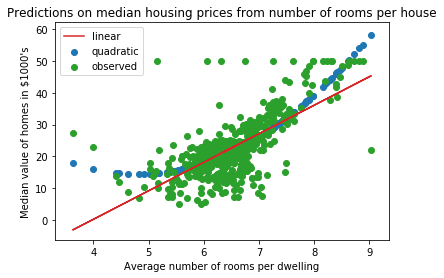

In [582]:
plt.plot(rm ,pred1, c='C3', label='linear')
plt.scatter(rm,pred2, c='C0', label='quadratic')
plt.scatter(rm, y, c = 'C2',label='observed')
plt.title("Predictions on median housing prices from number of rooms per house")
plt.xlabel("Average number of rooms per dwelling")
plt.ylabel("Median value of homes in $1000's")
plt.legend()

## Part 2: Gradient descent: Linear Regression

This is where it gets fun!

### 2.1 Implement gradient descent with one independent variable (average rooms per house)

Implement the batch gradient descent algorithm that we discussed in class. Use the version you implement to regress the housing price on the number of rooms per house. Experiment with 3-4 different values of the learning rate *R*, and do the following:

* Report the values of alpha and beta that minimize the loss function
* Report the number of iterations it takes for your algorithm to converge (for each value of *R*)
* Report the total running time of your algorithm, in seconds
* How do your coefficients compare to the ones estimated through standard libraries? Does this depend on *R*?

Some skeleton code is provided below, but you should feel free to delete this code and start from scratch if you prefer.

* *Hint 1: Don't forget to implement a stopping condition, so that at every iteration you check whether your results have converged. Common approaches to this are to (a) check to see if the loss has stopped decreasing; and (b) check if both your current parameter esimates are close to the estimates from the previous iteration.  In both cases, "close" should not be ==0, it should be <=epsilon, where epsilon is something very small (like 0.0001).*
* *Hint 2: Some people like to include a MaxIterations parameter in their gradient descent algorithm, to prevent divergence. *

In [583]:
import time

"""
Function
--------
bivariate_ols
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalues, yvalues : narray
    xvalues: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
ini_alpha: float
    initial alpha

ini_beta: float
    initial beta

epsilon: float
    convergence threshold
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta: float
    co-efficient
    
total_time: float
    running time

iterations: int
    number of iterations
    
    
"""
def bivariate_ols(xvalues, yvalues, ini_alpha, ini_beta, R, epsilon, MaxIterations):
    # initialize the parameters
    start_time = time.time()
    
    alpha = ini_alpha
    beta = ini_beta

    for i in range(MaxIterations):
        
        # update coefficients
        alpha_new = alpha - ((R/len(yvalues)) * np.sum(alpha + beta * xvalues - yvalues))
        beta_new = beta - ((R/len(yvalues)) * np.sum((alpha + beta * xvalues - yvalues) * xvalues))
    
        # check for stopping criteria
        if (np.abs(alpha_new-alpha)<epsilon) & (np.abs(beta_new-beta)<epsilon):
            alpha = alpha_new
            beta = beta_new
            break
        else:
            alpha = alpha_new
            beta = beta_new

    iterations = i+1

    end_time = time.time()
    total_time = end_time - start_time
    
    return alpha, beta, total_time, iterations

In [584]:
x = data['RM'].values
y = data['MEDV'].values

# initial alpha, beta
ini_alpha = -10
ini_beta = 6

# R = 0.0001
alpha3, beta3, total_time3 , iterations3 = bivariate_ols(x, y, ini_alpha, ini_beta, R=0.0001, epsilon=0.0001, MaxIterations=10000)
print('R = 0.0001')
print('alpha value = {}'.format(alpha3))
print('beta value  = {}'.format(beta3))
print('time taken  = {}s'.format(total_time3))
print('iterations  = {}'.format(iterations3))

# R = 0.001
alpha2, beta2, total_time2 , iterations2 = bivariate_ols(x, y, ini_alpha, ini_beta, R=0.001, epsilon=0.0001, MaxIterations=10000)
print('R = 0.001')
print('alpha value = {}'.format(alpha2))
print('beta value  = {}'.format(beta2))
print('time taken  = {}s'.format(total_time2))
print('iterations  = {}'.format(iterations2))

# R = 0.01
alpha1, beta1, total_time1 , iterations1 = bivariate_ols(x, y, ini_alpha, ini_beta, R=0.01, epsilon=0.0001, MaxIterations=10000)
print('R = 0.01')
print('alpha value = {}'.format(alpha1))
print('beta value  = {}'.format(beta1))
print('time taken  = {}s'.format(total_time1))
print('iterations  = {}'.format(iterations1))


R = 0.0001
alpha value = -10.160513232912816
beta value  = 5.110124769602543
time taken  = 0.0359189510345459s
iterations  = 837
R = 0.001
alpha value = -12.885209905324688
beta value  = 5.501123768457125
time taken  = 0.30045199394226074s
iterations  = 10000
R = 0.01
alpha value = -27.45887117765605
beta value  = 7.722596446176507
time taken  = 0.2824690341949463s
iterations  = 10000


When we have a learning rate of 0.01, and 0.001, we find that we go through all 10,000 iterations. This is probably because the learning rates are too large, and so it is not able to converge. When we use a learning rate of 0.0001, we find that we only go throiugh 837 iterations. From 1.2, the linear model had a slope value of 8.96. From our model with the learning rate of 0.0001, we get a beta value of 5.11. What I also noticed is that when I change the initial alpha and beta values, we get different approximations from the model.

### 2.2 Data normalization (done for you!)

Soon, you will implement a version of gradient descent that can use an arbitrary number of independent variables. Before doing this, we want to give you some code in case you want to standardize your features.

In [585]:
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

### 2.3 Implement gradient descent with an arbitrary number of independent variables

Now that you have a simple version of gradient descent working, create a version of gradient descent that can take more than one independent variable.  Assume all independent variables will be continuous.  Test your algorithm using CRIM and RM as independent variables. Standardize these variables before before inputting them to the gradient descent algorithm. 

As before,  report and interpret your estimated coefficients, the number of iterations before convergence, and the total running time of your algorithm. Experiment with 2-3 different values of R.

* *Hint 1: Be careful to implement this efficiently, otherwise it might take a long time for your code to run. Commands like `np.dot` can be a good friend to you on this problem*

In [586]:
"""
Function
--------
multivariate_ols
    Gradient Decent to minimize OLS. Used to find co-efficients of multivariate OLS Linear regression

Parameters
----------
xvalues, yvalues : narray
    xvalues: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
ini_alpha: float
    initial alpha

ini_beta: float
    initial beta

epsilon: float
    convergence threshold
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta: float
    co-efficient
    
total_time: float
    running time

iterations: int
    number of iterations
    
    
"""
def multivariate_ols(xvalues, yvalues, ini_alpha, ini_beta, R, epsilon, MaxIterations):
    # initialize the parameters
    start_time = time.time()
    
    alpha = ini_alpha
    beta = ini_beta

    for i in range(MaxIterations):
        
        # update coefficients
        alpha_new = alpha - ((R/len(yvalues)) * np.sum(alpha + np.sum(beta * xvalues,axis=1) - yvalues))
        beta_new = beta - ((R/len(yvalues)) * np.sum((alpha + np.sum(beta * xvalues,axis=1) - yvalues) * (xvalues.T),axis=1))
    
        # check for stopping criteria
        if (np.abs(alpha_new-alpha)<epsilon) & (np.abs(beta_new-beta)<epsilon).all():
            alpha = alpha_new
            beta = beta_new
            break
        else:
            alpha = alpha_new
            beta = beta_new
    
    iterations = i+1

    end_time = time.time()
    total_time = end_time - start_time
    
    return alpha, beta, total_time, iterations

In [587]:
x = standardize(data[['RM','CRIM']].values)
y = data['MEDV'].values

# initial alpha, beta
ini_alpha = -10
ini_beta = [6,6]

# R = 0.0001
alpha3, beta3, total_time3 , iterations3 = multivariate_ols(x, y, ini_alpha, ini_beta, R=0.0001, epsilon=0.0001, MaxIterations=10000)
print('R = 0.0001')
print('alpha value = {:.3f}'.format(alpha3))
print('beta value  = {:.3f},{:.3f}'.format(beta3[0],beta3[1]))
print('time taken  = {}s'.format(total_time3))
print('iterations  = {}'.format(iterations3))

# R = 0.001
alpha2, beta2, total_time2 , iterations2 = multivariate_ols(x, y, ini_alpha, ini_beta, R=0.001, epsilon=0.0001, MaxIterations=10000)
print('R = 0.001')
print('alpha value = {:.3f}'.format(alpha2))
print('beta value  = {:.3f},{:.3f}'.format(beta2[0],beta2[1]))
print('time taken  = {}s'.format(total_time2))
print('iterations  = {}'.format(iterations2))

# R = 0.01
alpha1, beta1, total_time1 , iterations1 = multivariate_ols(x, y, ini_alpha, ini_beta, R=0.01, epsilon=0.0001, MaxIterations=10000)
print('R = 0.01')
print('alpha value = {:.3f}'.format(alpha1))
print('beta value  = {:.3f},{:.3f}'.format(beta1[0],beta1[1]))
print('time taken  = {}s'.format(total_time1))
print('iterations  = {}'.format(iterations1))

R = 0.0001
alpha value = 10.565
beta value  = 6.570,0.880
time taken  = 0.5759470462799072s
iterations  = 10000
R = 0.001
alpha value = 22.433
beta value  = 5.862,-2.192
time taken  = 0.35030031204223633s
iterations  = 5783
R = 0.01
alpha value = 22.523
beta value  = 5.825,-2.235
time taken  = 0.049242258071899414s
iterations  = 806


Looking at the our values above, when we have a learning rate of 0.01, our model only requires 806 iterations. When we have a learning rate of 0.001, we go through 5783 iterations. Finally, when we have a learning rate of 0.0001, we go through all 10,000 iterations. This is the opposite scenario to what we found in 2.1. The alpha and beta values for R=0.01 and R=0.001 are relatively similar. This could be because the learning rate is so small, we need to go through more iterations for the model to converge.

### 2.4 Compare standardized vs. non-standardized results

Repeat the analysis from 2.3, but this time do not standardize your variables - i.e., use the original data. Use the same three values of R (0.1, 0.01, and 0.001). What do you notice about the running time and convergence properties of your algorithm?

In [593]:
x = data[['RM','CRIM']].values
y = data['MEDV'].values

# initial alpha, beta
ini_alpha = -10
ini_beta = [6,6]

# R = 0.0001
alpha3, beta3, total_time3 , iterations3 = multivariate_ols(x, y, ini_alpha, ini_beta, R=0.0001, epsilon=0.0001, MaxIterations=10000)
print('R = 0.0001')
print('alpha value = {:.3f}'.format(alpha3))
print('beta value  = {:.3f},{:.3f}'.format(beta3[0],beta3[1]))
print('time taken  = {}s'.format(total_time3))
print('iterations  = {}'.format(iterations3))

# R = 0.001
alpha2, beta2, total_time2 , iterations2 = multivariate_ols(x, y, ini_alpha, ini_beta, R=0.001, epsilon=0.0001, MaxIterations=10000)
print('R = 0.001')
print('alpha value = {:.3f}'.format(alpha2))
print('beta value  = {:.3f},{:.3f}'.format(beta2[0],beta2[1]))
print('time taken  = {}s'.format(total_time2))
print('iterations  = {}'.format(iterations2))

# R = 0.01
alpha1, beta1, total_time1 , iterations1 = multivariate_ols(x, y, ini_alpha, ini_beta, R=0.01, epsilon=0.0001, MaxIterations=10000)
print('R = 0.01')
print('alpha value = {:.3f}'.format(alpha1))
print('beta value  = {:.3f},{:.3f}'.format(beta1[0],beta1[1]))
print('time taken  = {}s'.format(total_time1))
print('iterations  = {}'.format(iterations1))

R = 0.0001
alpha value = -10.162
beta value  = 5.235,-0.314
time taken  = 0.08112001419067383s
iterations  = 1208
R = 0.001
alpha value = -12.131
beta value  = 5.561,-0.320
time taken  = 0.6050879955291748s
iterations  = 10000
R = 0.01
alpha value = -23.112
beta value  = 7.215,-0.284
time taken  = 0.6290569305419922s
iterations  = 10000


When we do not standardize the variables, the learning rate of 0.01 and 0.001 go through all 10,000 iterations, while the learning rate of 0.0001 goes through 1208 iterations. This is the opposite from the case in 2.3. Because the learning rate of 0.001 and 0.01 goes through all 10,000 iterations, they have a longer running time compared t0 in 2.3.

### **2.5 Implement  Mini-Batch Gradient Descent (MB-GD)**
MB-GD is a Gradient Descent variant that in large data sets can converge faster and is computationally less intensive. Implement MB-GD for question 2.3. Tune the learning rate, number of iterations and "mini-batch" size
so that you compute the estimates within a 1e-2 tolerance. Do not use a batch-size greater than 32.
In summary you go over the entire data set for n epochs. At the beginning of each epoch you shuffle your data once and then you pick k batches (approximately k=#of data points/batch_size). For each batch you compute the gradient, update the parameters and move to the next batch.
MB-GD is similar to Stochastic Gradient Descent but instead of using one sample to compute the gradient we use a batch of samples at each iteration. You can find details about MB-GD here:
https://en.wikipedia.org/wiki/Stochastic_gradient_descent

In [596]:
def MB_GD_ols(xvalues, yvalues, ini_alpha, ini_beta, num_batch, R, epsilon, MaxIterations):
    # initialize the parameters
    start_time = time.time()
    
    alpha = ini_alpha
    beta = ini_beta
    
    for i in range(MaxIterations):
        # Shuffle and split into batches
        kf = KFold(n_splits=num_batch,shuffle=True)
        batch_index = []
        for a, batch in kf.split(x):
            batch_index.append(batch)
        
        for j in range(num_batch):
        
            # update coefficients
            alpha_new = alpha - ((R/len(yvalues[batch_index[j]])) * np.sum(alpha + np.sum(beta * xvalues[batch_index[j]],axis=1) - yvalues[batch_index[j]]))
            beta_new = beta - ((R/len(yvalues[batch_index[j]])) * np.sum((alpha + np.sum(beta * xvalues[batch_index[j]],axis=1) - yvalues[batch_index[j]]) * (xvalues[batch_index[j]].T),axis=1))
    
        # check for stopping criteria
            if (np.abs(alpha_new-alpha)<epsilon) & (np.abs(beta_new-beta)<epsilon).all():
                alpha = alpha_new
                beta = beta_new
                break
            else:
                alpha = alpha_new
                beta = beta_new
    
        iterations = i+1

    end_time = time.time()
    total_time = end_time - start_time
    
    return alpha, beta, total_time, iterations

In [597]:
x = standardize(data[['RM','CRIM']].values)
y = data['MEDV'].values

# initial alpha, beta
ini_alpha = -10
ini_beta = [6,6]

# R = 0.0001, 25 batches, 10000 iterations
alpha1, beta1, total_time1 , iterations1 = MB_GD_ols(x, y, ini_alpha, ini_beta,num_batch = 25, R=0.0001, epsilon=0.01, MaxIterations=10000)
print('R = 0.0001, 25 batches, 10000 iterations')
print('alpha value = {:.3f}'.format(alpha1))
print('beta value  = {:.3f},{:.3f}'.format(beta1[0],beta1[1]))
print('time taken  = {}s'.format(total_time1))
print('iterations  = {}'.format(iterations1))

# R = 0.0001, 20 batches, 10000 iterations
alpha2, beta2, total_time2 , iterations2 = MB_GD_ols(x, y, ini_alpha, ini_beta,num_batch = 25, R=0.0001, epsilon=0.01, MaxIterations=10000)
print('R = 0.0001, 20 batches, 10000 iterations')
print('alpha value = {:.3f}'.format(alpha2))
print('beta value  = {:.3f},{:.3f}'.format(beta2[0],beta2[1]))
print('time taken  = {}s'.format(total_time2))
print('iterations  = {}'.format(iterations2))

# R = 0.001, 25 batches, 10000 iterations
alpha3, beta3, total_time3 , iterations3 = MB_GD_ols(x, y, ini_alpha, ini_beta,num_batch = 25, R=0.001, epsilon=0.01, MaxIterations=10000)
print('R = 0.001, 25 batches, 10000 iterations')
print('alpha value = {:.3f}'.format(alpha3))
print('beta value  = {:.3f},{:.3f}'.format(beta3[0],beta3[1]))
print('time taken  = {}s'.format(total_time3))
print('iterations  = {}'.format(iterations3))

# R = 0.001, 20 batches, 10000 iterations
alpha4, beta4, total_time4 , iterations4 = MB_GD_ols(x, y, ini_alpha, ini_beta,num_batch = 25, R=0.001, epsilon=0.01, MaxIterations=10000)
print('R = 0.001, 20 batches, 10000 iterations')
print('alpha value = {:.3f}'.format(alpha4))
print('beta value  = {:.3f},{:.3f}'.format(beta4[0],beta4[1]))
print('time taken  = {}s'.format(total_time4))
print('iterations  = {}'.format(iterations4))

# R = 0.01, 25 batches, 10000 iterations
alpha5, beta5, total_time5 , iterations5 = MB_GD_ols(x, y, ini_alpha, ini_beta,num_batch = 25, R=0.001, epsilon=0.01, MaxIterations=10000)
print('R = 0.01, 25 batches, 10000 iterations')
print('alpha value = {:.3f}'.format(alpha5))
print('beta value  = {:.3f},{:.3f}'.format(beta5[0],beta5[1]))
print('time taken  = {}s'.format(total_time5))
print('iterations  = {}'.format(iterations5))

# R = 0.01, 20 batches, 10000 iterations
alpha6, beta6, total_time6 , iterations6 = MB_GD_ols(x, y, ini_alpha, ini_beta,num_batch = 25, R=0.001, epsilon=0.01, MaxIterations=10000)
print('R = 0.01, 20 batches, 10000 iterations')
print('alpha value = {:.3f}'.format(alpha6))
print('beta value  = {:.3f},{:.3f}'.format(beta6[0],beta6[1]))
print('time taken  = {}s'.format(total_time6))
print('iterations  = {}'.format(iterations6))


R = 0.0001, 25 batches, 10000 iterations
alpha value = 10.561
beta value  = 6.602,0.880
time taken  = 5.508195638656616s
iterations  = 10000
R = 0.0001, 20 batches, 10000 iterations
alpha value = 10.551
beta value  = 6.546,0.887
time taken  = 5.285573244094849s
iterations  = 10000
R = 0.001, 25 batches, 10000 iterations
alpha value = 22.579
beta value  = 5.817,-2.215
time taken  = 5.2973408699035645s
iterations  = 10000
R = 0.001, 20 batches, 10000 iterations
alpha value = 22.543
beta value  = 5.841,-2.241
time taken  = 4.992336273193359s
iterations  = 10000
R = 0.01, 25 batches, 10000 iterations
alpha value = 22.534
beta value  = 5.911,-2.244
time taken  = 5.046231031417847s
iterations  = 10000
R = 0.01, 20 batches, 10000 iterations
alpha value = 22.476
beta value  = 5.849,-2.228
time taken  = 5.669514894485474s
iterations  = 10000


By tuning through the learning rates and batch sizes, we find that our running time did not speed up for convergence. For example,  from 2.3, our running time for a learning rate. of 0,01 was 0.04 seconds. In the case of the MB-GD, with the same learning rate of 0.01, our running time increased and went through the max number of iterations. The MB-GD function is made for each epoch to shuffle the data once and then pick k batches. For each batch, the gradient is computed, parameters updated, and moved to the next batch.

## 3. Prediction

Let's use our fitted model to make predictions about housing prices. Make sure to first standardize your features before proceeding.

### 3.1 Cross-Validation

Unless you were careful above, you probably overfit your data again. Let's fix that in one of two ways. If you're feeling confident, use k-fold cross-validation to re-fit the multivariate regression from 2.3 above, and report your estimated coefficients (there should be three, corresponding to the intercept and the two coefficients for CRIM and RM). Or if you want to do the quick and dirty version, randomly divide your data into a training set (66%) and testing set (34%) and use the training set to re-fit the regression from 2.3 above. 

*NOTE: * If using k-fold cross-validation, you will end up with a different set of parameters for each fold. In this case, use the parameters from the fold that has the highest test performance.

In [598]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.34)

x_train = standardize(train[['RM','CRIM']].values)
y_train = train['MEDV'].values

ini_alpha = -10
ini_beta = [6,6]

# R = 0.001 using 66% training set
alpha1, beta1, total_time1 , iterations1 = multivariate_ols(x_train, y_train, ini_alpha, ini_beta, R=0.001, epsilon=0.0001, MaxIterations=10000)
print('R = 0.001, 66% training set')
print('alpha value = {:.3f}'.format(alpha1))
print('beta value  = {:.3f},{:.3f}'.format(beta1[0],beta1[1]))
print('time taken  = {}s'.format(total_time1))
print('iterations  = {}'.format(iterations1))

# R = 0.001, part from 2.3. Using all training set
alpha2, beta2, total_time2 , iterations2 = multivariate_ols(x, y, ini_alpha, ini_beta, R=0.001, epsilon=0.0001, MaxIterations=10000)
print('R = 0.001, Q2.3, all training set')
print('alpha value = {:.3f}'.format(alpha2))
print('beta value  = {:.3f},{:.3f}'.format(beta2[0],beta2[1]))
print('time taken  = {}s'.format(total_time2))
print('iterations  = {}'.format(iterations2))




R = 0.001, 66% training set
alpha value = 22.360
beta value  = 5.774,-2.060
time taken  = 0.38711094856262207s
iterations  = 5781
R = 0.001, Q2.3, all training set
alpha value = 22.433
beta value  = 5.862,-2.192
time taken  = 0.3760650157928467s
iterations  = 5783


The coefficient values are around the same when using the 66% of the data, and using all of the data. When using 66% of the data for training, the model used less iterations. There is also no significant difference in running time. This is a good sign to see that we have similar coefficient values when training on less observations.

### 3.2 Predicted values and RMSE

Let's figure out how accurate this predictive model turned out to be. Compute the RMSE on your test cases, i.e. take the model parameters that you found above, predict the values for just the test instances, and compare the actual to the predicted values. If you did this the k-fold way above, this will be the average RMSE across the k test sets. If you did this the quick and dirty way above, this will just be the RMSE on your single test set.

What is your test RMSE?  How does it compare to the performance of your nearest neighbor algorithm from the last problem set?

In [599]:
x_test = standardize(test[['RM','CRIM']].values)
y_test = test[['MEDV']].values

$ y_{predict} = \alpha + x_{1}\beta_{1} + x_{2}\beta_{2} $

In [600]:
y_predict = (alpha1) + (x_test[:,0]*beta1[0]) + (x_test[:,1]*beta1[1])
RMSE = compute_rmse(y_predict, y_test)

print('RMSE value for prediction = {}'.format(RMSE))

RMSE value for prediction = 147.32412596663806


The test RMSE value we get is 6.8023. This value is much lower than the RMSE value 10.21 that we got from the nearest neighbor algorithm in the last problem. As mentioned from 3.1, the model trained that used 66% of the training data gave coefficient values that were very similar to the values from training on 100% of the data.

### Extra Credit 1: Logistic Regression

For extra credit, implement logistic regression using gradient descent. Create a new variable (EXPENSIVE) to indicate whether the median housing price is more than $40,000. Use your model  a logistic regression of EXPENSIVE on CHAS and RM. Report your results.

In [601]:
# Your code here

*Discuss your results here*

## 4 Regularization 

### 4.1 Get prepped

Step 1: Create new interaction variables between each possible pair of the F_s features. If you originally had *K* features, you should now have K+(K*(K+1))/2 features. Standardize all of your features.

Step 2: For simplicity, generate a single training and testing set.  Randomly sample 66% of your data and call this the training set, and set aside the remaining 34% as your test set.

In [602]:
len(data.columns)

14

In [603]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.218960,18.0,2.629288,0.0,0.869420,6.875396,65.2,4.347275,1.0,307.0,15.534711,397.462329,5.715647,24.0
1,0.141576,0.0,7.315612,0.0,0.549711,6.499894,78.9,5.315684,2.0,255.0,17.914131,397.012611,9.338417,21.6
2,0.380457,0.0,7.340354,0.0,0.697928,7.263489,61.1,5.356935,2.0,243.0,17.919989,396.628236,4.142473,34.7
3,0.313563,0.0,2.562407,0.0,0.599629,7.209732,45.8,6.103983,3.0,226.0,18.979527,398.564784,3.239272,33.4
4,0.330105,0.0,2.497337,0.0,0.476077,7.184111,54.2,6.264372,3.0,234.0,18.708888,399.487766,6.115159,36.2


In [604]:
x_data = data.drop(['MEDV'],axis=1)
x_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.218960,18.0,2.629288,0.0,0.869420,6.875396,65.2,4.347275,1.0,307.0,15.534711,397.462329,5.715647
1,0.141576,0.0,7.315612,0.0,0.549711,6.499894,78.9,5.315684,2.0,255.0,17.914131,397.012611,9.338417
2,0.380457,0.0,7.340354,0.0,0.697928,7.263489,61.1,5.356935,2.0,243.0,17.919989,396.628236,4.142473
3,0.313563,0.0,2.562407,0.0,0.599629,7.209732,45.8,6.103983,3.0,226.0,18.979527,398.564784,3.239272
4,0.330105,0.0,2.497337,0.0,0.476077,7.184111,54.2,6.264372,3.0,234.0,18.708888,399.487766,6.115159


In [605]:
num_features = len(x_data.columns)
for i in range(num_features):
    for j in range(i, num_features):
        col = x_data.columns[i] +'*'+ x_data.columns[j]
        x_data[col] = x_data.iloc[:,i] * x_data.iloc[:,i]
        
print(len(x_data.columns))

104


In [606]:
x_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,TAX*TAX,TAX*PTRATIO,TAX*B,TAX*LSTAT,PTRATIO*PTRATIO,PTRATIO*B,PTRATIO*LSTAT,B*B,B*LSTAT,LSTAT*LSTAT
0,0.218960,18.0,2.629288,0.0,0.869420,6.875396,65.2,4.347275,1.0,307.0,...,94249.0,94249.0,94249.0,94249.0,241.327253,241.327253,241.327253,157976.303016,157976.303016,32.668615
1,0.141576,0.0,7.315612,0.0,0.549711,6.499894,78.9,5.315684,2.0,255.0,...,65025.0,65025.0,65025.0,65025.0,320.916074,320.916074,320.916074,157619.013024,157619.013024,87.206031
2,0.380457,0.0,7.340354,0.0,0.697928,7.263489,61.1,5.356935,2.0,243.0,...,59049.0,59049.0,59049.0,59049.0,321.126013,321.126013,321.126013,157313.957558,157313.957558,17.160083
3,0.313563,0.0,2.562407,0.0,0.599629,7.209732,45.8,6.103983,3.0,226.0,...,51076.0,51076.0,51076.0,51076.0,360.222430,360.222430,360.222430,158853.886758,158853.886758,10.492886
4,0.330105,0.0,2.497337,0.0,0.476077,7.184111,54.2,6.264372,3.0,234.0,...,54756.0,54756.0,54756.0,54756.0,350.022485,350.022485,350.022485,159590.475176,159590.475176,37.395171


In [607]:
x_data['MEDV'] = data['MEDV']

train, test = train_test_split(x_data, test_size=0.34, shuffle=True)

In [608]:
train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,TAX*PTRATIO,TAX*B,TAX*LSTAT,PTRATIO*PTRATIO,PTRATIO*B,PTRATIO*LSTAT,B*B,B*LSTAT,LSTAT*LSTAT,MEDV
237,0.687641,0.0,6.406245,0.0,0.674074,7.428125,71.6,4.347051,8.0,314.0,...,98596.0,98596.0,98596.0,307.253497,307.253497,307.253497,154917.835393,154917.835393,24.951474,31.5
471,4.047467,0.0,18.319182,0.0,0.620994,6.239441,90.7,3.101021,24.0,670.0,...,448900.0,448900.0,448900.0,418.077306,418.077306,418.077306,156340.739283,156340.739283,175.271989,19.6
43,0.269147,0.0,6.957769,0.0,0.787734,6.498970,6.5,5.890210,3.0,233.0,...,54289.0,54289.0,54289.0,329.166981,329.166981,329.166981,156551.588791,156551.588791,64.635221,24.7
52,0.333204,21.0,5.828966,0.0,0.836908,6.521196,21.1,6.927974,4.0,252.0,...,63504.0,63504.0,63504.0,282.552984,282.552984,282.552984,158512.941262,158512.941262,33.772276,25.0
184,0.201968,0.0,2.628632,0.0,0.700411,5.694222,89.8,3.250913,3.0,193.0,...,37249.0,37249.0,37249.0,323.680511,323.680511,323.680511,154692.879011,154692.879011,204.639551,26.4


### 4.2 Overfitting (sort of)
Now, using your version of multivariate regression from 2.3, let's overfit the training data. Using your training set, regress housing price on as many of those K+(K*(K+1))/2 features as you can (Don't forget to add quadratic terms. Form instance, RM^2.).  If you get too greedy, it's possible this will take a long time to compute, so start with 5-10 features, and if you have the time, add more features.

Report the RMSE when you apply your model to your training set and to your testing set. How do these numbers compare to each other, and to the RMSE from 3.2 and nearest neighbors?

In [609]:
# We regress on the first 30 features

x_train = standardize(train.iloc[:,0:30].values)
y_train = train['MEDV'].values

x_test = standardize(test.iloc[:,0:30].values)
y_test = test['MEDV'].values

# Initial beta values is an array of 2
ini_alpha = -10
ini_beta = np.zeros(30)+2

train_alpha, train_beta, train_total_time, train_iterations = multivariate_ols(x_train, y_train, ini_alpha, ini_beta, R=0.001, epsilon=0.0001, MaxIterations=10000)
print('R = 0.001')
print('time taken to find coefficients  = {}s'.format(train_total_time))
print('iterations  = {}'.format(train_iterations))

# Initialize train_y_predict to alpha value, and then we add all the betas through the for loop
train_y_predict = train_alpha

for i in range(0,30):
    train_y_predict += x_train[:,i]*train_beta[i]

# Initialize test_y_predict to alpha value, and then we add all the betas through the for loop on the test data
test_y_predict = train_alpha

for i in range(0,30):
    test_y_predict += x_test[:,i]*train_beta[i]


R = 0.001
time taken to find coefficients  = 0.8666369915008545s
iterations  = 9192


Compute RMSE cost

In [610]:
RMSE_train = compute_rmse(train_y_predict, y_train)
RMSE_test = compute_rmse(test_y_predict, y_test)

print('RMSE value on training set = {}'.format(RMSE_train))
print('RMSE value on testing set = {}'.format(RMSE_test))

RMSE value on training set = 4.850498423654782
RMSE value on testing set = 4.814002127320451


The RMSE value for the training set is 4.526. The RMSE value for the testing set is 5.3066. These values are less than the RMSE value we got from 3.2 which was 6.802. Because the model is very overfitted, we should normally expect a much higher RMSE value on the testing set. However, the RMSE value on the testing set is not that much higher than the RMSE on the training set, and it is still lower than the value in 3.2. This value is also lower than the RMSE value of 10.21 from the nearest neighbors problem set.

### 4.3 Ridge regularization
Incorporate L2 (Ridge) regularization into your multivariate_ols regression. Write a new version of your gradient descent algorithm that includes a regularization term "lambda" to penalize excessive complexity. 

Use your regularized regression to re-fit the model from 4.2 above on your training data. Try this for several different values of lambda, and report your RMSE for each lambda separately for your training and testing data. How do these numbers compare to each other, to the RMSE from 4.2,  to the RMSE from 2.3, and to the RMSE from nearest neighbors?

Go brag to your friends about how you just implemented ridge-regularized multivariate regression using gradient descent optimization, from scratch. If you still have friends.

In [613]:
def ridge_multivariate_ols(xvalues, yvalues, ini_alpha, ini_beta, lamda, R, epsilon, MaxIterations):
    # initialize the parameters
    start_time = time.time()
    
    alpha = ini_alpha
    beta = ini_beta

    for i in range(MaxIterations):
        
        # update coefficients
        alpha_new = alpha - ((R/len(yvalues)) * np.sum(alpha + np.sum(beta * xvalues,axis=1) - yvalues))
        beta_new = (beta*(1-((lamda/len(yvalues))*R))) - ((R/len(yvalues)) * np.sum((alpha + np.sum(beta * xvalues,axis=1) - yvalues) * (xvalues.T),axis=1))
    
        # check for stopping criteria
        if (np.abs(alpha_new-alpha)<epsilon) & (np.abs(beta_new-beta)<epsilon).all():
            alpha = alpha_new
            beta = beta_new
            break
        else:
            alpha = alpha_new
            beta = beta_new
    
    iterations = i+1

    end_time = time.time()
    total_time = end_time - start_time
    
    return alpha, beta, total_time, iterations

Using same model from 4.2 that has the first 30 features

In [614]:
x_train = standardize(train.iloc[:,0:30].values)
y_train = train['MEDV'].values

x_test = standardize(test.iloc[:,0:30].values)
y_test = test['MEDV'].values

# Initial beta values is an array of 2
ini_alpha = -10
ini_beta = np.zeros(30)+2

# R = 0.0001, lambda = 1
alpha1, beta1, total_time1 , iterations1 = ridge_multivariate_ols(x_train, y_train, ini_alpha, ini_beta, lamda = 1, R=0.0001, epsilon=0.0001, MaxIterations=10000)
train_y_predict1 = alpha1
test_y_predict1 = alpha1
for i in range(0,30):
    train_y_predict1 += x_train[:,i]*beta1[i]
for i in range(0,30):
    test_y_predict1 += x_test[:,i]*beta1[i]
RMSE_train1 = compute_rmse(train_y_predict1, y_train)
RMSE_test1 = compute_rmse(test_y_predict1, y_test)

print('R = 0.0001, lambda = 1')
print('alpha value = {:.3f}'.format(alpha1))
print('beta value  = {:.3f},{:.3f}'.format(beta1[0],beta1[1]))
print('time taken  = {}s'.format(total_time1))
print('iterations  = {}'.format(iterations1))
print('RMSE value on training set = {}'.format(RMSE_train1))
print('RMSE value on testing set = {}'.format(RMSE_test1))
print('')

# R = 0.0001, lambda = 0.1
alpha2, beta2, total_time2 , iterations2 = ridge_multivariate_ols(x_train, y_train, ini_alpha, ini_beta,lamda = 0.1, R=0.0001, epsilon=0.0001, MaxIterations=10000)
train_y_predict2 = alpha2
test_y_predict2 = alpha2
for i in range(0,30):
    train_y_predict2 += x_train[:,i]*beta2[i]
for i in range(0,30):
    test_y_predict2 += x_test[:,i]*beta2[i]
RMSE_train2 = compute_rmse(train_y_predict2, y_train)
RMSE_test2 = compute_rmse(test_y_predict2, y_test)

print('R = 0.0001, lambda = 0.1')
print('alpha value = {:.3f}'.format(alpha2))
print('beta value  = {:.3f},{:.3f}'.format(beta2[0],beta2[1]))
print('time taken  = {}s'.format(total_time2))
print('iterations  = {}'.format(iterations2))
print('RMSE value on training set = {}'.format(RMSE_train2))
print('RMSE value on testing set = {}'.format(RMSE_test2))
print('')

# R = 0.001, lambda = 0.01
alpha3, beta3, total_time3 , iterations3 = ridge_multivariate_ols(x_train, y_train, ini_alpha, ini_beta, lamda = 0.01, R=0.001, epsilon=0.0001, MaxIterations=10000)
train_y_predict3 = alpha3
test_y_predict3 = alpha3
for i in range(0,30):
    train_y_predict3 += x_train[:,i]*beta3[i]
for i in range(0,30):
    test_y_predict3 += x_test[:,i]*beta3[i]
RMSE_train3 = compute_rmse(train_y_predict3, y_train)
RMSE_test3 = compute_rmse(test_y_predict3, y_test)

print('R = 0.001, lambda = 0.01')
print('alpha value = {:.3f}'.format(alpha3))
print('beta value  = {:.3f},{:.3f}'.format(beta3[0],beta3[1]))
print('time taken  = {}s'.format(total_time3))
print('iterations  = {}'.format(iterations3))
print('RMSE value on training set = {}'.format(RMSE_train3))
print('RMSE value on testing set = {}'.format(RMSE_test3))
print('')

# R = 0.001, lambda = 0.001
alpha4, beta4, total_time4 , iterations4 = ridge_multivariate_ols(x_train, y_train, ini_alpha, ini_beta, lamda = 0.001, R=0.001, epsilon=0.0001, MaxIterations=10000)
train_y_predict4 = alpha4
test_y_predict4 = alpha4
for i in range(0,30):
    train_y_predict4 += x_train[:,i]*beta4[i]
for i in range(0,30):
    test_y_predict4 += x_test[:,i]*beta4[i]
RMSE_train4 = compute_rmse(train_y_predict4, y_train)
RMSE_test4 = compute_rmse(test_y_predict4, y_test)

print('R = 0.001, lambda = 0.001')
print('alpha value = {:.3f}'.format(alpha4))
print('beta value  = {:.3f},{:.3f}'.format(beta4[0],beta4[1]))
print('time taken  = {}s'.format(total_time4))
print('iterations  = {}'.format(iterations4))
print('RMSE value on training set = {}'.format(RMSE_train4))
print('RMSE value on testing set = {}'.format(RMSE_test4))
print('')

R = 0.0001, lambda = 1
alpha value = 10.838
beta value  = -0.378,0.502
time taken  = 1.0191171169281006s
iterations  = 10000
RMSE value on training set = 13.506393748618953
RMSE value on testing set = 12.238873540476634

R = 0.0001, lambda = 0.1
alpha value = 10.838
beta value  = -0.378,0.503
time taken  = 1.0980238914489746s
iterations  = 10000
RMSE value on training set = 13.507167694316287
RMSE value on testing set = 12.240092118998312

R = 0.001, lambda = 0.01
alpha value = 22.961
beta value  = 0.127,0.004
time taken  = 0.8798139095306396s
iterations  = 9192
RMSE value on training set = 4.850504591619886
RMSE value on testing set = 4.813984903980081

R = 0.001, lambda = 0.001
alpha value = 22.961
beta value  = 0.127,0.004
time taken  = 0.9239199161529541s
iterations  = 9192
RMSE value on training set = 4.8504990401704
RMSE value on testing set = 4.814000404673516



From 4.3 above, the lowest RMSE value we got was with a lambda value of 0.001. However, the RMSE values for both lambda values of 0.01 and 0.001 are very very similar. They are 4.5256 for the training set, and 5.3066 for the testing set. These RMSE values are exactly the same as the RMSE values we got from 4.2. These values are less than the RMSE values for 3.2 which is 6.802, and lower than the RMSE value from the nearest neighbor problem set, which had a value of 10.21. It is interesting to note that when the lambda values were set high to 0.1 or 1, the RMSE values increase significantly to 13.19 on the training set, and 13.97 on the testing set. 

### Extra Credit 2: Cross-validate lambda

Use k-fold cross-validation to select the optimal value of lambda. Report the average RMSE across all training sets, and the average RMSE across all testing sets. How do these numbers compare to each other, to the RMSE from your previous efforts?  Finally, create a scatter plot that shows RMSE as a function of lambda.

In [4]:
# Your code here

*Discuss your results here*

###  Extra Credit 3: AdaGrad

AdaGrad is a method to implement gradient descent with different learning rates for each feature. Adaptive algorithms like this one are being extensively used especially in neural network training. Implement AdaGrad on 2.3 but now use CRIM, RM and DIS as independent variables. Standardize these variables before inputting them to the gradient descent algorithm. Tune the algorithm until you estimate the regression coefficients within a tolerance of 1e-1. Use mini-batch gradient descent in this implementation. In summary for each parameter (in our case one intercept and three slopes) the update step of the gradient (in this example $\beta_j$) at iteration $k$ of the GD algorithm becomes:

$$\beta_j=\beta_j -\frac{R}{\sqrt{G^{(k)}_j}}\frac{\partial J(\alpha,\beta_1,\ldots)}{\partial \beta_j}$$ where
$G^{(k)}_j=\sum_{i=1}^{k} (\frac{\partial J^{(i)}(\alpha,\beta_1,\ldots)}{\partial \beta_j})^2$ and $R$ is your learning rate. The notation $\frac{\partial J^{(i)}(\alpha,\beta_1,\ldots)}{\partial \beta_j}$ corresponds to the value of the gradient at iteration $(i)$. Essentially we are "storing" information about previous iteration gradients. Doing that we effectively decrease the learning rate slower when a feature $x_i$ is sparse (i.e. has many zero values which would lead to zero gradients). Although this method is not necessary for our regression problem, it is good to be familiar with these methods as they are widely used in neural network training.  

In [ ]:
# Your code here

*Discuss your results here*